In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model,Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings("ignore")

2024-04-26 19:51:50.741508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:51:50.741625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:51:50.864506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path="/kaggle/input/chest-ctscan-images/Data/train"
val_path="/kaggle/input/chest-ctscan-images/Data/valid"
test_path="/kaggle/input/chest-ctscan-images/Data/test"

In [3]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'normal': 148, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195} 

 {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'normal': 13, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'adenocarcinoma': 120, 'large.cell.carcinoma': 51}


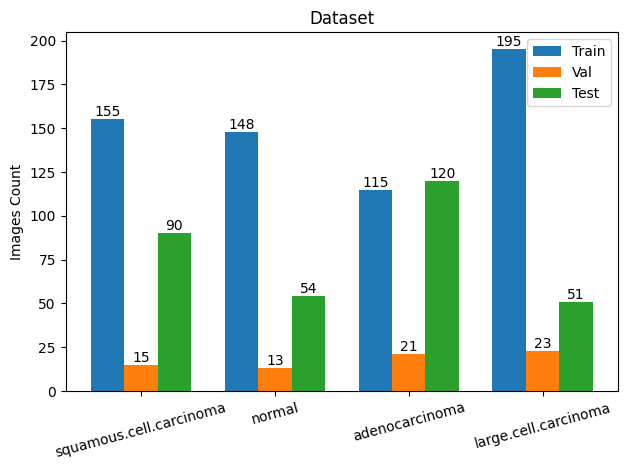

In [4]:
# Labels of each classes
labels=['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

train_list=list(train_set.values())
val_list=list(val_set.values())
test_list=list(test_set.values())

# labels location and the bars width
x=np.arange(len(labels))
width=0.25


# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

In [5]:
# Image data generator with specified augmentation configurations (mostly geometric transformations)
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices


Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [6]:
# Image data generator with specified augmentation configurations (mostly geometric transformations)
val_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [7]:
# Image data generator with specified augmentation configurations (mostly geometric transformations)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

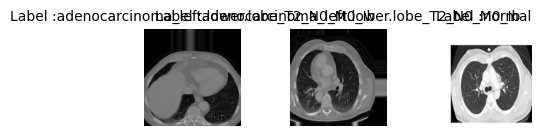

In [8]:
# visualization 
def plot_sample_images(images,labels,class_indices):
    class_labels=list(class_indices.keys())
    fig, axs=plt.subplots(1,len(images),figsize=(5,5))
    fig.subplots_adjust(wspace=0.5)
    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title('Label :{}'.format(class_labels[np.argmax(labels[i])]),fontsize=10)
        axs[i].axis('off')
    plt.show()
    
sample_images, sample_labels=next(train_data)
plot_sample_images(sample_images[:3],sample_labels[:3],train_data.class_indices)
    
    

VGG-16
Visual Geometry Group 16-layer is a deep convolutional neural architecture designed for image classification.Trained on the ImageNet dataset,this model exhibits an accuracy exceeding 80%.

Batch size:32 
Epochs: 32 
Input Shape:(350,350,3)
Output layer:16

In [9]:
base_model=VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(350,350,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Training the model**

In [10]:
num_classes=4
vgg_model=Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(num_classes,activation='sigmoid'))
vgg_model.layers[0].trainable=False

vgg_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])


In [11]:
# Fitting the Model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
     
    )

Epoch 1/32
  2/122 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.3000 - loss: 1.5780  

I0000 00:00:1714161148.337723      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714161148.361338      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4466 - loss: 2.6303

W0000 00:00:1714161186.140652      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 62s 333ms/step - accuracy: 0.4469 - loss: 2.6292 - val_accuracy: 0.5000 - val_loss: 1.6378
Epoch 2/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.4000 - loss: 2.7110 - val_accuracy: 0.5000 - val_loss: 0.7622
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.5426 - loss: 2.0160 - val_accuracy: 0.3714 - val_loss: 3.0677
Epoch 4/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.6000 - loss: 1.8627 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.5631 - loss: 2.0754 - val_accuracy: 0.5000 - val_loss: 2.1250
Epoch 6/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.8000 - loss: 0.2989 - val_accuracy: 0.5000 - val_loss: 2.9916
Epoch 7/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - accuracy: 0.6318 - loss: 1.6180 - val_accuracy: 0.5143 - val_loss: 2.2040
Epoch 8/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.6000 - loss: 1.3386 - val_acc

In [12]:
loss_vgg,vgg_accuracy = vgg_model.evaluate(test_data, steps=test_data.samples // test_data.batch_size)

print("Accuracy of the model:", vgg_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.6485 - loss: 1.6511
Accuracy of the model: 0.6761904954910278


In [13]:
base_model=EfficientNetB0(weights='imagenet',
                    include_top=False,
                    input_shape=(350,350,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [15]:

EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)


EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
EffNetB0 = EffNetmodel.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size
    )

Epoch 1/32
  2/122 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.2500 - loss: 1.4634     

W0000 00:00:1714161687.981024      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/122 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.4359 - loss: 1.3021

W0000 00:00:1714161757.763281      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.4959 - loss: 1.1719

W0000 00:00:1714161778.520210      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/122 ━━━━━━━━━━━━━━━━━━━━ 205s 764ms/step - accuracy: 0.4964 - loss: 1.1707 - val_accuracy: 0.1857 - val_loss: 2.0587
Epoch 2/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6000 - loss: 0.7023 - val_accuracy: 0.0000e+00 - val_loss: 2.8033
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.6466 - loss: 0.8732 - val_accuracy: 0.1571 - val_loss: 1.6270
Epoch 4/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.4000 - loss: 1.1876 - val_accuracy: 0.0000e+00 - val_loss: 1.9329
Epoch 5/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.6970 - loss: 0.6866 - val_accuracy: 0.2000 - val_loss: 2.7639
Epoch 6/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.8000 - loss: 0.4716 - val_accuracy: 0.5000 - val_loss: 0.8020
Epoch 7/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.6938 - loss: 0.7024 - val_accuracy: 0.3286 - val_loss: 1.5650
Epoch 8/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.8000 - loss: 0.4136 -

In [17]:
loss_EffNetB0,EffNetB0_accuracy = EffNetmodel.evaluate(test_data, steps=test_data.samples // test_data.batch_size)

print("Accuracy of the model:", EffNetB0_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.5457 - loss: 1.1759
Accuracy of the model: 0.49841269850730896


**Make prediction**

In [18]:
def ScanPrediction(path, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])
        
        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Label: Large cell carcinoma
Actual Label: Large cell carcinoma


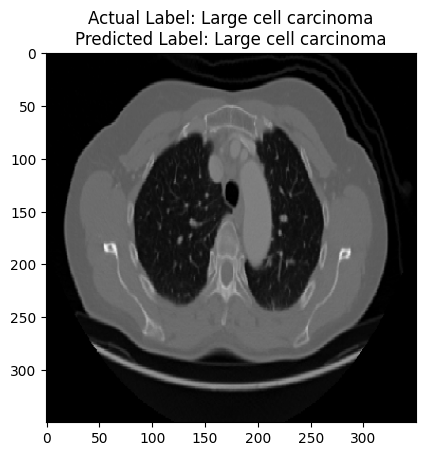

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: Large cell carcinoma
Actual Label: Adenocarcinoma


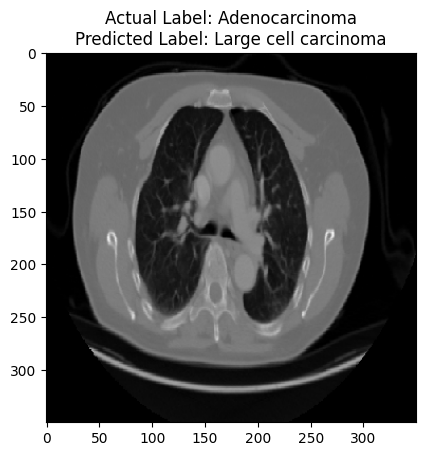

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: Normal
Actual Label: Normal


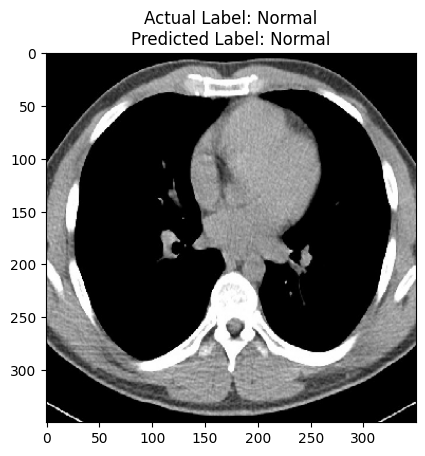

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: Large cell carcinoma
Actual Label: Squamous cell carcinoma


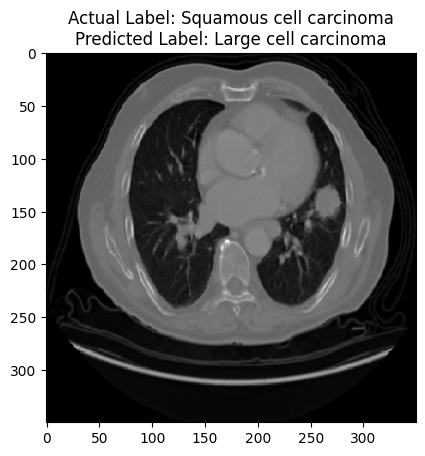

In [19]:
paths = [
    "/kaggle/input/chest-ctscan-images/Data/test/large.cell.carcinoma/000128.png",
    "/kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000114.png",
    "/kaggle/input/chest-ctscan-images/Data/test/normal/21.png",
    "/kaggle/input/chest-ctscan-images/Data/test/squamous.cell.carcinoma/000119.png"
]

actual_labels = [1, 0, 2, 3]

ScanPrediction(paths, EffNetmodel, actual_labels)